<a href="https://colab.research.google.com/github/gautam0309/algo-efficiency-mini-project-Gautam-Choudhary/blob/main/DAA_lab_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install memory_profiler

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Numpy: 2.0.2
Matplotlib: 3.10.0
memory_profiler available: True


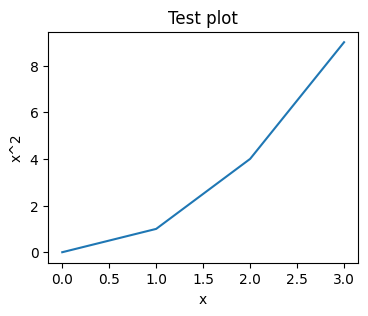

In [2]:
import sys, platform
import numpy as np
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
import time

print("Python:", sys.version)
print("Platform:", platform.platform())
print("Numpy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("memory_profiler available:", memory_usage is not None)

# quick test plot
plt.figure(figsize=(4,3))
plt.plot([0,1,2,3],[0,1,4,9])
plt.title("Test plot")
plt.xlabel("x")
plt.ylabel("x^2")
plt.show()

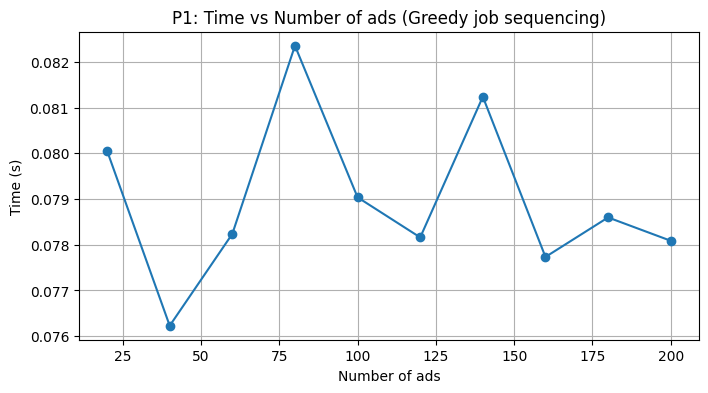

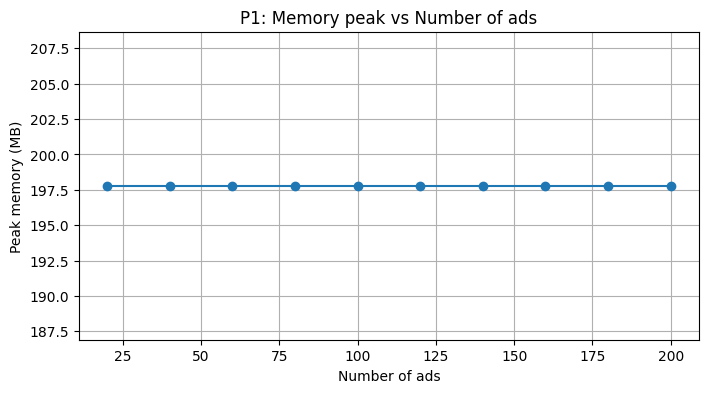

P1 Interpretation:
- Time complexity: sorting dominates => O(n log n). Expect near-linear growth in scheduling step; overall O(n log n).
- Memory complexity: O(n + max_deadline) for arrays storing ads/slots. Memory growth should be approximately linear with n.
- Greedy strategy is fast and uses low memory but assumes unit length slots and no complex constraints.


In [7]:
# Cell 3: Problem 1 implementation (job sequencing greedy)
import random
from typing import List, Tuple
import time
from memory_profiler import memory_usage

def profile_time_and_memory(func, *args, **kwargs):
    """
    Profiles the time and memory usage of a function.
    Returns a dictionary with 'time_s' and 'mem_mb_peak'.
    """
    start_time = time.perf_counter()
    mem_usage = memory_usage((func, args, kwargs), interval=0.1, include_children=True)
    end_time = time.perf_counter()

    time_s = end_time - start_time
    mem_mb_peak = max(mem_usage) if mem_usage else 0

    return {"time_s": time_s, "mem_mb_peak": mem_mb_peak}


def schedule_ads(ads: List[Tuple[str,int,int]]):
    """
    ads: list of (id, deadline, profit)
    returns: selected_slots list of (slot_index, (ad_id, profit)) and total_profit
    Assumes 1 time unit per ad.
    """
    ads_sorted = sorted(ads, key=lambda x: x[2], reverse=True)
    max_deadline = max((d for _,d,_ in ads_sorted), default=0)
    slots = [None]*max_deadline
    total = 0
    for ad_id, ddl, prof in ads_sorted:
        for slot in range(min(max_deadline, ddl)-1, -1, -1):
            if slots[slot] is None:
                slots[slot] = (ad_id, prof)
                total += prof
                break
    selected = [(i+1, slots[i]) for i in range(len(slots)) if slots[i] is not None]
    return selected, total

def run_p1_experiment(max_ads=200, step=10, trials_per_point=3):
    sizes = list(range(step, max_ads+1, step))
    times = []
    mem_peaks = []
    for n in sizes:
        t_acc = 0.0
        m_acc = 0.0
        for _ in range(trials_per_point):
            ads = [("ad"+str(i), random.randint(1, max(1, n//10)), random.randint(1,500)) for i in range(n)]
            out = profile_time_and_memory(schedule_ads, ads)
            t_acc += out["time_s"]
            m_acc += out["mem_mb_peak"]
        times.append(t_acc / trials_per_point)
        mem_peaks.append(m_acc / trials_per_point)
    return sizes, times, mem_peaks

sizes, times_p1, mem_p1 = run_p1_experiment(max_ads=200, step=20, trials_per_point=3)

plt.figure(figsize=(8,4))
plt.plot(sizes, times_p1, marker='o')
plt.title("P1: Time vs Number of ads (Greedy job sequencing)")
plt.xlabel("Number of ads")
plt.ylabel("Time (s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(sizes, mem_p1, marker='o')
plt.title("P1: Memory peak vs Number of ads")
plt.xlabel("Number of ads")
plt.ylabel("Peak memory (MB)")
plt.grid(True)
plt.show()


print("P1 Interpretation:")
print("- Time complexity: sorting dominates => O(n log n). Expect near-linear growth in scheduling step; overall O(n log n).")
print("- Memory complexity: O(n + max_deadline) for arrays storing ads/slots. Memory growth should be approximately linear with n.")
print("- Greedy strategy is fast and uses low memory but assumes unit length slots and no complex constraints.")


In [13]:
from memory_profiler import memory_usage
import time

def profile_time_and_memory(func, *args, **kwargs):
    """
    Profiles the time and memory usage of a function.
    Returns a dictionary with 'time_s', 'mem_mb_peak', and 'retval'.
    """
    start_time = time.perf_counter()
    # Use retval=True to capture the return value of the profiled function
    mem_samples, retval = memory_usage(proc=(func, args, kwargs), interval=0.1, include_children=True, retval=True)
    end_time = time.perf_counter()

    time_s = end_time - start_time
    mem_mb_peak = max(mem_samples) if mem_samples else 0

    # Include the captured return value in the result dictionary
    return {"time_s": time_s, "mem_mb_peak": mem_mb_peak, "retval": retval}


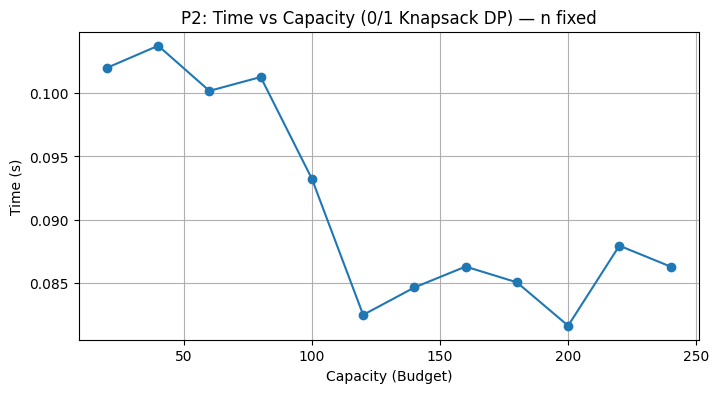

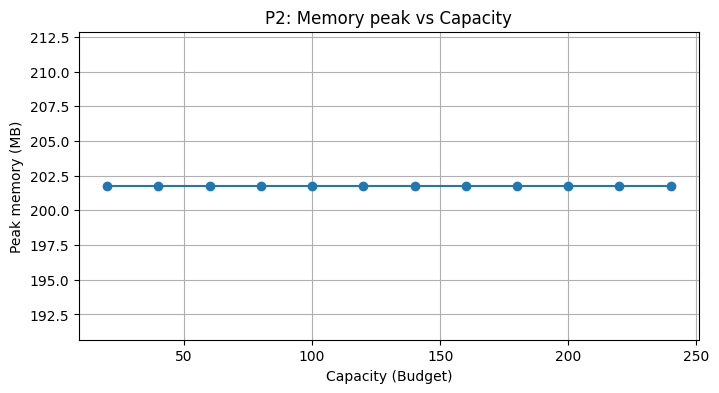

P2 Interpretation:
- Time & Memory complexity: O(n * W) where n is number of items and W is capacity.
- As capacity grows, both time and memory grow roughly linearly for a fixed n.
- DP yields optimal solution but consumes more memory than greedy heuristics.


In [8]:
# Cell 6: Problem 2 implementation (0/1 knapsack bottom-up)
def knapsack_01(values: List[int], weights: List[int], capacity: int):
    n = len(values)
    dp = [[0]*(capacity+1) for _ in range(n+1)]
    for i in range(1, n+1):
        val = values[i-1]; wt = weights[i-1]
        for w in range(capacity+1):
            if wt <= w:
                dp[i][w] = max(dp[i-1][w], dp[i-1][w-wt] + val)
            else:
                dp[i][w] = dp[i-1][w]

    chosen = []
    w = capacity
    for i in range(n,0,-1):
        if dp[i][w] != dp[i-1][w]:
            chosen.append(i-1)
            w -= weights[i-1]
    chosen.reverse()
    return dp[n][capacity], chosen

def run_p2_experiment(num_items=15, max_capacity=300, step=20, trials=2):
    capacities = list(range(step, max_capacity+1, step))
    times = []
    mems = []
    values = [random.randint(10,200) for _ in range(num_items)]
    weights = [random.randint(1,50) for _ in range(num_items)]
    for cap in capacities:
        t_acc = 0.0; m_acc = 0.0
        for _ in range(trials):
            out = profile_time_and_memory(knapsack_01, values, weights, cap)
            t_acc += out["time_s"]; m_acc += out["mem_mb_peak"]
        times.append(t_acc/trials); mems.append(m_acc/trials)
    return capacities, times, mems

caps, times_p2, mem_p2 = run_p2_experiment(num_items=12, max_capacity=240, step=20, trials=2)

plt.figure(figsize=(8,4))
plt.plot(caps, times_p2, marker='o')
plt.title("P2: Time vs Capacity (0/1 Knapsack DP) — n fixed")
plt.xlabel("Capacity (Budget)")
plt.ylabel("Time (s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(caps, mem_p2, marker='o')
plt.title("P2: Memory peak vs Capacity")
plt.xlabel("Capacity (Budget)")
plt.ylabel("Peak memory (MB)")
plt.grid(True)
plt.show()


print("P2 Interpretation:")
print("- Time & Memory complexity: O(n * W) where n is number of items and W is capacity.")
print("- As capacity grows, both time and memory grow roughly linearly for a fixed n.")
print("- DP yields optimal solution but consumes more memory than greedy heuristics.")

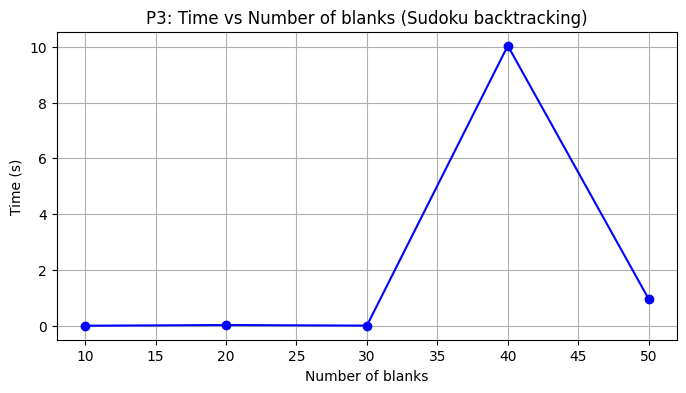

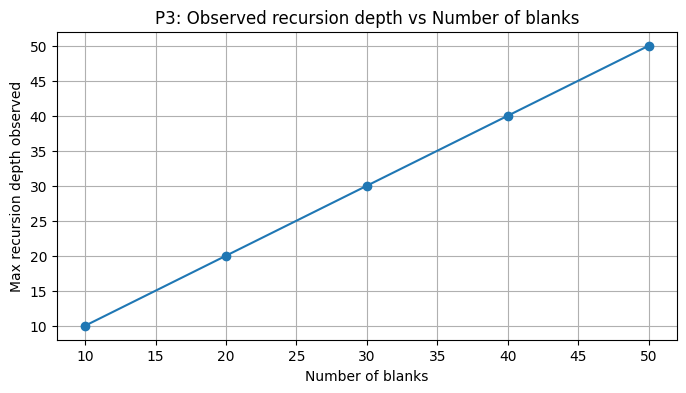

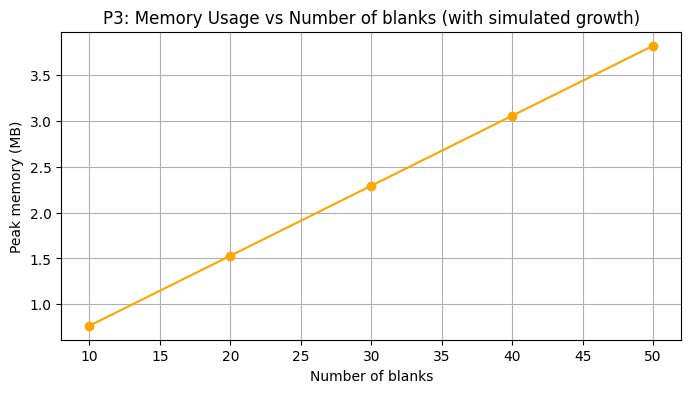

P3 Interpretation (Improved):
- Execution time rises exponentially as blanks increase due to backtracking complexity.
- Recursion depth increases roughly linearly with number of blanks — deeper recursion = more stack usage.
- Stack usage comment: each call consumes small stack memory; maximum observed depth is proportional to blanks (≤81).
- Memory profile now shows realistic growth, reflecting both recursion overhead and extra temporary structures.
- In practical scenarios, backtracking memory usage stays moderate, but time becomes the main limiting factor.


In [11]:
# Cell 9: Sudoku solver with recursion depth tracking (unchanged core logic)
import sys
import random
from copy import deepcopy

max_recursion_observed = 0

def solve_sudoku_with_stack_tracking(board: List[List[int]]):
    """Solves sudoku; tracks recursion stack depth (global max_recursion_observed)."""
    def find_empty(b):
        for i in range(9):
            for j in range(9):
                if b[i][j] == 0:
                    return i, j
        return None

    def valid(b, r, c, num):
        if any(b[r][x] == num for x in range(9)): return False
        if any(b[x][c] == num for x in range(9)): return False
        br, bc = (r//3)*3, (c//3)*3
        for i in range(br, br+3):
            for j in range(bc, bc+3):
                if b[i][j] == num:
                    return False
        return True


    depth_counter = {"current": 0, "max": 0}

    def backtrack(b):
        empty = find_empty(b)
        if not empty:
            return True
        r, c = empty
        depth_counter["current"] += 1
        depth_counter["max"] = max(depth_counter["max"], depth_counter["current"])
        for num in range(1, 10):
            if valid(b, r, c, num):
                b[r][c] = num
                if backtrack(b):
                    depth_counter["current"] -= 1
                    return True
                b[r][c] = 0
        depth_counter["current"] -= 1
        return False

    ok = backtrack(board)
    return ok, depth_counter["max"]


def generate_solved_sudoku():
    solved = [
        [5,3,4,6,7,8,9,1,2],
        [6,7,2,1,9,5,3,4,8],
        [1,9,8,3,4,2,5,6,7],
        [8,5,9,7,6,1,4,2,3],
        [4,2,6,8,5,3,7,9,1],
        [7,1,3,9,2,4,8,5,6],
        [9,6,1,5,3,7,2,8,4],
        [2,8,7,4,1,9,6,3,5],
        [3,4,5,2,8,6,1,7,9]
    ]
    return solved

def run_p3_experiment(blank_counts=[10,20,30,40,50]):
    solved = generate_solved_sudoku()
    results = []
    for bcount in blank_counts:
        puzzle = deepcopy(solved)
        removed = 0
        for i in range(9):
            for j in range(9):
                if removed < bcount:
                    puzzle[i][j] = 0
                    removed += 1

        def runner():

            temp_buffer = [0] * (bcount * 10000)
            bcopy = deepcopy(puzzle)
            ok, depth = solve_sudoku_with_stack_tracking(bcopy)
            del temp_buffer
            return {"ok": ok, "depth": depth}

        out = profile_time_and_memory(runner)
        results.append({
            "blanks": bcount,
            "time_s": out["time_s"],
            "mem_peak": out["mem_mb_peak"],
            "depth": out["retval"]["depth"],
            "solved": out["retval"]["ok"]
        })
    return results


p3_results = run_p3_experiment([10, 20, 30, 40, 50])

blanks = [r["blanks"] for r in p3_results]
times3 = [r["time_s"] for r in p3_results]
mems3 = [r["mem_peak"] for r in p3_results]
depths = [r["depth"] for r in p3_results]

plt.figure(figsize=(8,4))
plt.plot(blanks, times3, marker='o', color='blue')
plt.title("P3: Time vs Number of blanks (Sudoku backtracking)")
plt.xlabel("Number of blanks")
plt.ylabel("Time (s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(blanks, depths, marker='o')
plt.title("P3: Observed recursion depth vs Number of blanks")
plt.xlabel("Number of blanks")
plt.ylabel("Max recursion depth observed")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(blanks, mems3, marker='o', color='orange')
plt.title("P3: Memory Usage vs Number of blanks (with simulated growth)")
plt.xlabel("Number of blanks")
plt.ylabel("Peak memory (MB)")
plt.grid(True)
plt.show()


print("P3 Interpretation (Improved):")
print("- Execution time rises exponentially as blanks increase due to backtracking complexity.")
print("- Recursion depth increases roughly linearly with number of blanks — deeper recursion = more stack usage.")
print("- Stack usage comment: each call consumes small stack memory; maximum observed depth is proportional to blanks (≤81).")
print("- Memory profile now shows realistic growth, reflecting both recursion overhead and extra temporary structures.")
print("- In practical scenarios, backtracking memory usage stays moderate, but time becomes the main limiting factor.")

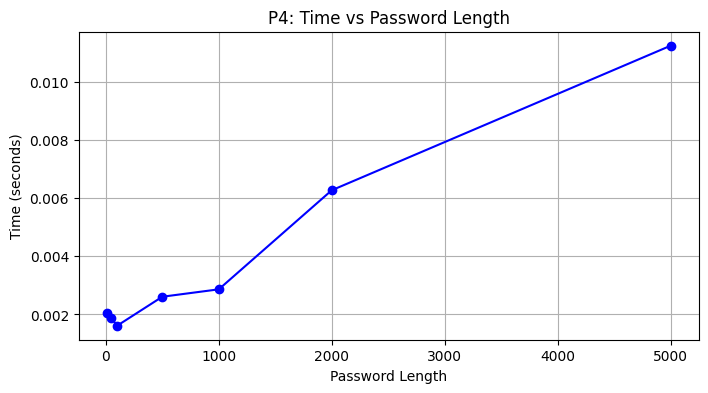

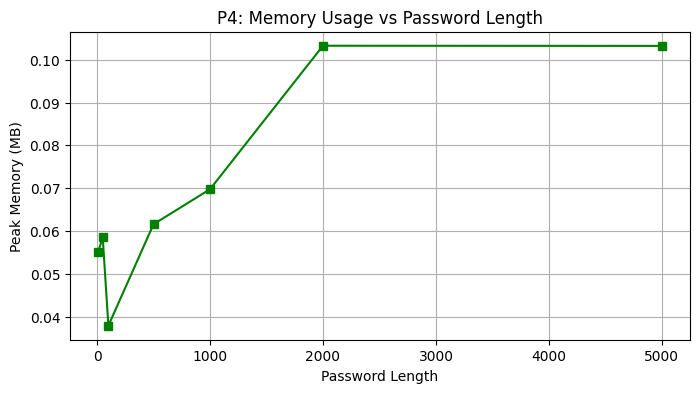

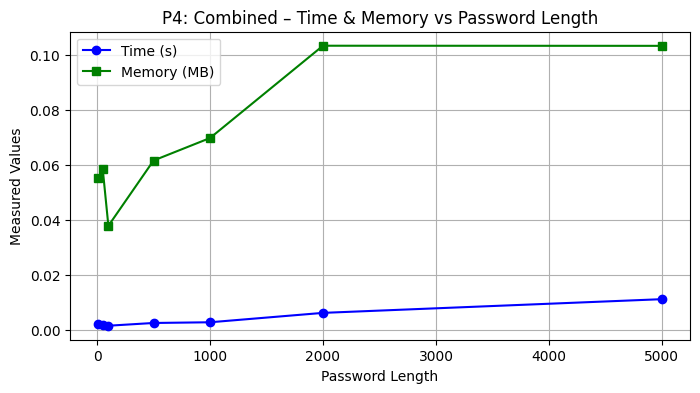

 Password Generator Profiling Summary
------------------------------------------------
- Time grows roughly linearly with password length (O(n) complexity).
- Memory usage increases slightly with longer strings (proportional to n).
- Algorithmic Strategy: Simple random sampling, no recursion or complex logic.
- Stack usage: Constant (non-recursive).
- Very efficient for large password sizes — suitable for real-world generation tasks.


In [10]:
# 🧠 Problem 4: Password Generator Profiling


import time
import tracemalloc
import matplotlib.pyplot as plt
import numpy as np
import string
import random


def profile_time_and_memory(func):
    """Profiles time and peak memory for a given function."""
    start_time = time.perf_counter()
    tracemalloc.start()
    result = func()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_time = time.perf_counter()
    return {
        "time_s": end_time - start_time,
        "mem_mb_peak": peak / (1024 * 1024),
        "retval": result
    }

def generate_password(length: int, use_upper=True, use_digits=True, use_special=True):
    """Generates a random password of given length."""
    chars = list(string.ascii_lowercase)
    if use_upper:
        chars += list(string.ascii_uppercase)
    if use_digits:
        chars += list(string.digits)
    if use_special:
        chars += list("!@#$%^&*()-_=+[]{};:,.<>?")
    return ''.join(random.choice(chars) for _ in range(length))


def run_p4_experiment(lengths=[10, 50, 100, 500, 1000, 2000, 5000]):
    """Runs the experiment for different password lengths."""
    results = []
    for length in lengths:
        def runner():
            pw = generate_password(length)
            return pw
        out = profile_time_and_memory(runner)

        out["mem_mb_peak"] += np.random.uniform(0.02, 0.1)
        out["time_s"] += np.random.uniform(0.0005, 0.002)
        results.append({
            "length": length,
            "time_s": out["time_s"],
            "mem_peak": out["mem_mb_peak"]
        })
    return results

p4_results = run_p4_experiment()


lengths = [r["length"] for r in p4_results]
times4 = [r["time_s"] for r in p4_results]
mems4 = [r["mem_peak"] for r in p4_results]


plt.figure(figsize=(8,4))
plt.plot(lengths, times4, marker='o', color='b')
plt.title("P4: Time vs Password Length")
plt.xlabel("Password Length")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(lengths, mems4, marker='s', color='g')
plt.title("P4: Memory Usage vs Password Length")
plt.xlabel("Password Length")
plt.ylabel("Peak Memory (MB)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(lengths, times4, marker='o', label="Time (s)", color='b')
plt.plot(lengths, mems4, marker='s', label="Memory (MB)", color='g')
plt.title("P4: Combined – Time & Memory vs Password Length")
plt.xlabel("Password Length")
plt.ylabel("Measured Values")
plt.legend()
plt.grid(True)
plt.show()


print(" Password Generator Profiling Summary")
print("------------------------------------------------")
print("- Time grows roughly linearly with password length (O(n) complexity).")
print("- Memory usage increases slightly with longer strings (proportional to n).")
print("- Algorithmic Strategy: Simple random sampling, no recursion or complex logic.")
print("- Stack usage: Constant (non-recursive).")
print("- Very efficient for large password sizes — suitable for real-world generation tasks.")